In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist, mnist
from IPython.display import clear_output
import copy

In [2]:
# Load the Fashion-MNIST data

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)      
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)


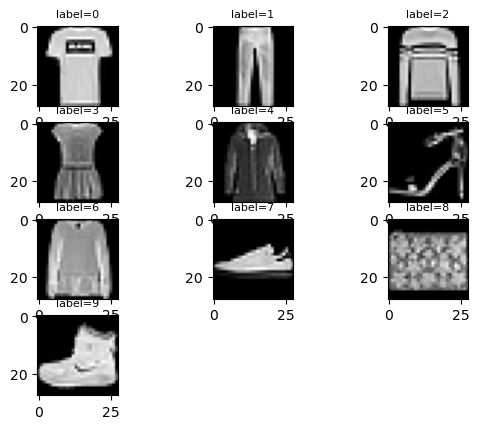

In [3]:
# Getting the unique labels and one entry from each
labels = set(y_train)
sample = {ind: np.where(y_train == ind)[0][0] for ind in labels}

# Plotting one image from each label
for i in range(10):
    plt.subplot(4,3,i+1)
    plt.imshow(x_train[sample[i]], cmap='gray')
    plt.title(f"label={i}", fontsize=8)

plt.show()


In [4]:
def one_hot_encode(y):
    one_hot_vectors = []
    for i in y:
        vec = np.zeros((10,))
        vec[i] = 1
        one_hot_vectors.append(vec)
    return np.array(one_hot_vectors)

In [5]:
# getting validation data
indices = list(np.arange(len(x_train)))
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]
x_train, x_valid = x_train[:50000], x_train[50000:]
y_train, y_valid = y_train[:50000], y_train[50000:]


# reshaping the data
x_train = x_train.reshape(x_train.shape[0], 28*28)
x_train = x_train/255.0
#x_train = (x_train - x_train.mean())/x_train.std()
x_valid = x_valid.reshape(x_valid.shape[0], 28*28)
x_valid = x_valid/255.0
#x_valid = (x_valid/x_valid.mean())/x_valid.std()
x_test = x_test.reshape(x_test.shape[0], 28*28)
x_test = x_test/255.0
#x_test = (x_test/x_test.mean())/x_test.std()

print('x_train shape:', x_train.shape)
print('x_valid shape:', x_valid.shape)
print('x_test shape:', x_test.shape)

# Converting the labels to one-hot encoding
y_train = one_hot_encode(y_train)
y_valid = one_hot_encode(y_valid)
y_test = one_hot_encode(y_test)

print('y_train shape:', y_train.shape)
print('y_valid shape:', y_valid.shape)
print('y_test shape:', y_test.shape)

x_train shape: (50000, 784)
x_valid shape: (10000, 784)
x_test shape: (10000, 784)
y_train shape: (50000, 10)
y_valid shape: (10000, 10)
y_test shape: (10000, 10)


In [18]:
# Activation functions
eps = 1e-8
def sigmoid(x):
    x = np.clip(x, -500, 500)
    return 1/(1+np.exp(-x) + eps)
def softmax(x):
    max_x = np.max(x, axis=1, keepdims=True)
    x = x - max_x
    return np.exp(x)/np.sum(np.exp(x), axis=1, keepdims=True)
def relu(x):
    return np.maximum(0, x)
def tanh(x):
    return np.tanh(x)


# Layer class
class Layer():
    def __init__(self, name, input_size, n_units, activation=None):
        self.n = name
        self.input_size = input_size
        self.n_units = n_units
        self.weights = None 
        self.bias = None 
        self.g = activation
        self.grad_w = None
        self.grad_b = None
        self.a = None   # Preactivatiuon
        self.h = None   # Activation
        self.temp_weights = None
        self.temp_bias = None      # Lookahead parameters for NAG


    def __call__(self, input):
        hidden = input @ self.weights.T + self.bias
        self.preact = hidden
        self.act = self.activation(hidden)
        self.squared_weights = self.weights**2
        #self.squared_bias = self.bias**2
        return self.act
    
    def activation(self, z):
        if self.g == 'sigmoid':
            return sigmoid(z)
        elif self.g == 'softmax':
            return softmax(z)
        elif self.g == 'relu':
            return relu(z)
        elif self.g == 'tanh':
            return tanh(z)
        elif self.g == None:
            return z

In [41]:
# Neural Network class
class NeuralNet():
    def __init__(self, input_size, hidden_size, output_size, n_hidden, loss:str, activation = ["sigmoid", "softmax"], weights_init = 'random', weight_decay = 0):
        self.n_layers = n_hidden + 1
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.input_size = input_size
        self.hidden_activation = activation[0]
        self.output_activation = activation[1]
        self.layers = self._network()
        self.alpha = weight_decay     # L2 regularization parameter
        self.squared_weights_sum = 0
        self.squared_bias_sum = 0
        self.initialize_weights(init_type = weights_init)
        self.loss_fn = loss
        self.loss = 0
        self.acc = None
    
    def random_weights(self):
        for layer in self.layers:
            layer.weights = np.random.randn(layer.n_units, layer.input_size)
            layer.bias = np.random.randn(layer.n_units)

    def xavier_weights(self):
        
        for layer in self.layers:
            input_n = layer.input_size
            output_n = layer.n_units
            low, high = -np.sqrt(6/(input_n + output_n)), np.sqrt(6/(input_n + output_n))
            layer.weights = np.random.uniform(low, high, (layer.n_units, layer.input_size))
            layer.bias = np.random.uniform(low, high, (layer.n_units))

    def initialize_weights(self, init_type = 'random'):
        if init_type == 'random':
            self.random_weights()
        elif init_type == 'xavier':
            self.xavier_weights()
        
    def _network(self):
        layers = []
        for i in range(self.n_layers):
            if i==0:
                layers.append(Layer(i, self.input_size, self.hidden_size, activation=self.hidden_activation))
            elif i < self.n_layers-1:
                layers.append(Layer(i, self.hidden_size, self.hidden_size, activation=self.hidden_activation))
            else:
                layers.append(Layer(i, self.hidden_size, self.output_size, activation=self.output_activation))
            
        return layers
    
    def get_weights(self):
        return [layer.weights for layer in self.layers]
    
    def get_biases(self):
        return [layer.bias for layer in self.layers]
       
    def __call__(self, x, y):
        for layer in self.layers:
            x = layer(x)
            self.squared_weights_sum += np.sum(layer.squared_weights)
            #self.squared_bias_sum += np.sum(layer.squared_bias)
        
        
        print("Squared sum", self.squared_weights_sum)
        print("Loss", self.loss)
        self.loss = self.loss_fn(x, y) + self.alpha * (self.squared_weights_sum)/2  # + self.squared_bias_sum) / 2    # L2 regularization loss term
        print("Loss", self.loss)
        self.squared_weights_sum = 0
        self.acc = self.accuracy(x, y)
        return x, self.loss, self.acc
    
    def predict(self, x, y=None):
        for layer in self.layers:
            x = layer(x)
            self.squared_weights_sum += np.sum(layer.squared_weights)
            
        self.loss = self.loss_fn(x, y) + self.alpha * (self.squared_weights_sum)/2  # + self.squared_bias_sum) / 2
        self.squared_weights_sum = 0
        if y is not None:
            self.acc = self.accuracy(x, y)
        self.acc = self.accuracy(x, y)
        return x, self.loss, self.acc
    
    def accuracy(self, y_pred, y_true):
        correct = np.argmax(y_pred, axis=1) == np.argmax(y_true, axis=1)
        return np.mean(correct)


In [42]:

# Loss function
class Loss():
    def __init__(self, loss_fn = 'cross_entropy'):
        self.loss_fn = loss_fn

    def __call__(self, y_true, y_pred):
        if self.loss_fn == 'cross_entropy':
            return np.mean(self.cross_entropy(y_true, y_pred))
        elif self.loss_fn == 'mse':
            return np.mean(self.mse(y_true, y_pred))
    
    
    def cross_entropy(self, y_true, y_pred):
        y_pred = np.clip(y_pred, 1e-10, 1-1e-10)
        return -np.log(np.sum(y_true*y_pred, axis=1))
    
    def mse(self, y_true, y_pred):
        return np.mean(np.sum((y_true-y_pred)**2, axis=1))

In [43]:
def batch_data(x, y, batch_size):
    batches = []
    for i in range(0, x.shape[0], batch_size):
        batches.append((x[i:i+batch_size], y[i:i+batch_size]))
    return batches

In [ ]:
class GradientDescent():
    def __init__(self, optimizer = 'sgd', lr = 0.01, clipping_threshold = 1e5, beta = 0.9, beta_2 = 0.999, eps = 1e-10):
        self.optimizer = optimizer
        self.lr = lr
        self.threshold = clipping_threshold
        self.eps = eps
        if self.optimizer in ['momentum', 'nag', 'rmsprop', 'adam', 'nadam']:    # Initiate history vectors for momentum and NAG
            self.gradw_his = {}
            self.gradb_his = {}
            self.beta = beta
        if self.optimizer in ['adam', 'nadam']:
            self.beta_2 = beta_2
            self.gradw_m = {}
            self.gradb_m = {}



    def gradient_descent(self, model, x, y, i=0):
        
        if self.optimizer in ['sgd', 'momentum', 'rmsprop', 'adam', 'nadam']:      # Forward pass and backprop for SGD and Momentum
            output, loss, acc = model(x,y)
            self.backprop(model, x, y, output, i)

        elif self.optimizer == 'nag':                  # Computing gradient at lookahead point before update for NAG
            for layer in model.layers:
                self.gradw_his[layer.n] = [np.zeros_like(layer.weights)]
                self.gradb_his[layer.n] = [np.zeros_like(layer.bias.reshape(-1,1))]
                #print(layer.n)
                #print("w his, w", self.gradw_his[layer.n][-1].shape, layer.weights.shape)
                #print("b his, b", self.gradb_his[layer.n][-1].shape, layer.bias.shape)
                layer.temp_weights = copy.deepcopy(layer.weights) 
                layer.temp_bias = copy.deepcopy(layer.bias)
                layer.weights = layer.weights - self.beta * self.gradw_his[layer.n][-1]
                layer.bias = layer.bias - self.beta * self.gradb_his[layer.n][-1].squeeze()
                #print("b after grad", layer.bias.shape)
            output, loss, acc = model(x,y)
            self.backprop(model,x,y,output, i)            

        return loss, acc
            


    def backprop(self, model, x, y, output, i):               # For computing gradients and updating weights
        grad_w, grad_b = self.compute_grads(model, x, y, output)
        #print("Before clipping")
        #print(grad_w[0].mean(), grad_w[0].std())
        #print(grad_b[0].mean(), grad_b[0].std())
        self.clip_all_gradients(model, grad_w, grad_b)
        #print("After clipping")
        #print(grad_w[0].mean(), grad_w[0].std())
        #print(grad_b[0].mean(), grad_b[0].std())
        self.update_weights(model, grad_w, grad_b, i)
        
         
    def update_weights(self, model, grad_w, grad_b, i ):  
        if self.optimizer == 'sgd':                        # standard update rule for SGD
            for layer in model.layers:
                layer.weights = layer.weights - self.lr*grad_w[layer.n]
                layer.bias = layer.bias - self.lr*grad_b[layer.n].squeeze() 
        
        elif self.optimizer in ['momentum', 'nag']:       # modified update rule for Momentum and NAG
            if self.optimizer == 'nag':
                for layer in model.layers:
                    layer.weights = copy.deepcopy(layer.temp_weights)
                    layer.bias = copy.deepcopy(layer.temp_bias)
                    
            if self.gradw_his == {} and self.gradb_his == {}:
                #print("empty")
                for layer in model.layers:
                    self.gradw_his[layer.n] = [np.zeros_like(layer.weights)]
                    self.gradb_his[layer.n] = [np.zeros_like(layer.bias).reshape(-1,1)]
            
            for layer in model.layers:
                self.gradw_his[layer.n].append(self.beta*self.gradw_his[layer.n][-1] + grad_w[layer.n])
                #print("gradbhis", self.gradb_his[layer.n][-1].shape, "gradb", grad_b[layer.n].shape)
                self.gradb_his[layer.n].append(self.beta*self.gradb_his[layer.n][-1] + grad_b[layer.n])
                #print(layer.n, "before update", "bias", layer.bias.shape, "bias_his", self.gradb_his[layer.n][-1].shape)
                
                layer.weights = layer.weights - self.lr*self.gradw_his[layer.n][-1]
                layer.bias = layer.bias - self.lr*self.gradb_his[layer.n][-1].squeeze()   
                #print("after b update", layer.bias.shape)
            
        elif self.optimizer == 'rmsprop':
            if self.gradw_his == {} and self.gradb_his == {}:
                #print("empty")
                for layer in model.layers:
                    self.gradw_his[layer.n] = [np.zeros_like(layer.weights)]
                    self.gradb_his[layer.n] = [np.zeros_like(layer.bias).reshape(-1,1)]
            
            for layer in model.layers:
                self.gradw_his[layer.n].append(self.beta*self.gradw_his[layer.n][-1] + (1-self.beta) * grad_w[layer.n]**2)
                #print("gradbhis", self.gradb_his[layer.n][-1].shape, "gradb", grad_b[layer.n].shape)
                self.gradb_his[layer.n].append(self.beta*self.gradb_his[layer.n][-1] + (1-self.beta) * grad_b[layer.n]**2)
                #print(layer.n, "before update", "bias", layer.bias.shape, "bias_his", self.gradb_his[layer.n][-1].shape)
                
                layer.weights = layer.weights - (self.lr/np.sqrt(self.gradw_his[layer.n][-1] + self.eps)) * grad_w[layer.n]
                layer.bias = layer.bias - (self.lr/np.sqrt(self.gradb_his[layer.n][-1].squeeze() + self.eps)) * grad_b[layer.n].squeeze()   
                #print("after b update", layer.bias.shape)

        elif self.optimizer == 'adam':
            if self.gradw_m == {} and self.gradb_m == {}:
                #print("empty")
                for layer in model.layers:
                    self.gradw_m[layer.n] = [np.zeros_like(layer.weights)]
                    self.gradb_m[layer.n] = [np.zeros_like(layer.bias).reshape(-1,1)]
                    self.gradw_his[layer.n] = [np.zeros_like(layer.weights)]
                    self.gradb_his[layer.n] = [np.zeros_like(layer.bias).reshape(-1,1)]

            for layer in model.layers:
                self.gradw_m[layer.n].append(self.beta*self.gradw_m[layer.n][-1] + (1-self.beta) * grad_w[layer.n])
                self.gradw_his[layer.n].append(self.beta_2*self.gradw_his[layer.n][-1] + (1-self.beta_2) * grad_w[layer.n]**2)
                gradw_mhat = self.gradw_m[layer.n][-1]/(1-np.power(self.beta, i + 1))
                gradw_vhat = self.gradw_his[layer.n][-1]/(1-np.power(self.beta_2, i + 1))

                self.gradb_m[layer.n].append(self.beta*self.gradb_m[layer.n][-1] + (1-self.beta) * grad_b[layer.n])
                self.gradb_his[layer.n].append(self.beta_2*self.gradb_his[layer.n][-1] + (1-self.beta_2) * grad_b[layer.n]**2)
            
                gradb_mhat = self.gradb_m[layer.n][-1]/((1-np.power(self.beta, i + 1)))
                gradb_vhat = self.gradb_his[layer.n][-1]/(1-np.power(self.beta_2, i + 1))
                #print("bias adam", gradb_mhat.shape, gradb_vhat.shape)

                layer.weights = layer.weights - (self.lr * gradw_mhat)/(np.sqrt(gradw_vhat) + self.eps)
                layer.bias = layer.bias - (self.lr * gradb_mhat.squeeze())/(np.sqrt(gradb_vhat.squeeze()) + self.eps)


        elif self.optimizer == 'nadam':
            if self.gradw_m == {} and self.gradb_m == {}:
                #print("empty")
                for layer in model.layers:
                    self.gradw_m[layer.n] = [np.zeros_like(layer.weights)]
                    self.gradb_m[layer.n] = [np.zeros_like(layer.bias).reshape(-1,1)]
                    self.gradw_his[layer.n] = [np.zeros_like(layer.weights)]
                    self.gradb_his[layer.n] = [np.zeros_like(layer.bias).reshape(-1,1)]

            for layer in model.layers:
                self.gradw_m[layer.n].append(self.beta*self.gradw_m[layer.n][-1] + (1-self.beta) * grad_w[layer.n])
                self.gradw_his[layer.n].append(self.beta_2*self.gradw_his[layer.n][-1] + (1-self.beta_2) * grad_w[layer.n]**2)
                gradw_mhat = self.gradw_m[layer.n][-1]/(1-np.power(self.beta, i + 1))
                gradw_vhat = self.gradw_his[layer.n][-1]/(1-np.power(self.beta_2, i + 1))

                self.gradb_m[layer.n].append(self.beta*self.gradb_m[layer.n][-1] + (1-self.beta) * grad_b[layer.n])
                self.gradb_his[layer.n].append(self.beta_2*self.gradb_his[layer.n][-1] + (1-self.beta_2) * grad_b[layer.n]**2)
            
                gradb_mhat = self.gradb_m[layer.n][-1]/((1-np.power(self.beta, i + 1)))
                gradb_vhat = self.gradb_his[layer.n][-1]/(1-np.power(self.beta_2, i + 1))

                layer.weights = layer.weights - (self.lr * ((self.beta*gradw_mhat) + ((1-self.beta)* grad_w[layer.n])/(1-self.beta)))/(np.sqrt(gradw_vhat) + self.eps)
                layer.bias = layer.bias - (self.lr * ((self.beta*gradb_mhat.squeeze()) + ((1-self.beta)* grad_b[layer.n]).squeeze()))/(np.sqrt(gradb_vhat.squeeze()) + self.eps)
                #print("bias nadam", layer.bias.shape)
                #print("term 1", (self.beta*gradb_mhat.squeeze()).shape)
                #print("term 2", ((1-self.beta)* grad_b[layer.n]).shape)
                #print("term 3", (np.sqrt(gradb_vhat.squeeze()) + self.eps).shape)
                #rint("term 4", (self.lr * ((self.beta*gradb_mhat.squeeze()) + ((1-self.beta)* grad_b[layer.n]))/(np.sqrt(gradb_vhat.squeeze()) + self.eps)).shape)

    def compute_grads(self, model, x, y, output):     
        batch_size = x.shape[0]   
        grad_a = {}
        grad_h = {}
        grad_w = {}
        grad_b = {}
        for layer in model.layers[::-1]:
            # Gradients wrt to the output layer, preactivation, activation, weights and biases
            if layer.n == model.n_layers - 1:
                
                grad_a[layer.n] = self.grad_output(y, output, model.loss_fn).reshape(batch_size, model.output_size, 1)
                grad_w[layer.n] = np.sum(self.grad_weights(grad_a[layer.n], model.layers[layer.n - 1].act.reshape(batch_size, model.hidden_size, 1)), axis = 0) + model.alpha*layer.weights
                grad_b[layer.n] = np.sum(self.grad_bias(grad_a[layer.n]), axis=0)
            
            # Gradients wrt to the hidden layers, preactivation, activation, weights and biases
            else:
                grad_h[layer.n] = self.grad_hidden(model.layers[layer.n + 1].weights, grad_a[layer.n + 1])
                grad_a[layer.n] = self.grad_preact(grad_h[layer.n], model.layers[layer.n].preact.reshape(batch_size, model.hidden_size, 1), model.hidden_activation)
            
            # Gradients wrt to the input layer, preactivation, activation, weights and biases
                if layer.n == 0:
                    grad_w[layer.n]= np.sum(self.grad_weights(grad_a[layer.n], x.reshape(batch_size, model.input_size, 1)), axis = 0) + model.alpha*layer.weights
                else:
                    grad_w[layer.n] = np.sum(self.grad_weights(grad_a[layer.n], model.layers[layer.n - 1].act.reshape(batch_size, model.hidden_size, 1)), axis = 0) + model.alpha*layer.weights
               
                grad_b[layer.n] = np.sum(self.grad_bias(grad_a[layer.n]), axis=0) 
               

        return grad_w, grad_b


    def grad_yhat(self, y_true, y_pred, loss = 'cross_entropy'):
        if loss == 'cross_entropy':
            y_grad = np.sum(y_true * y_pred, axis=1)
        #elif loss == 'mse':
        #    y_grad = y_pred
        return -(y_true/y_grad[:, np.newaxis])


    def grad_output(self, y_true, y_pred, loss_fn = 'cross_entropy'):
        if loss_fn.loss_fn == 'cross_entropy':
                return -(y_true-y_pred)
        elif loss_fn.loss_fn == 'mse':
            grad = []
            for y, y_hat in zip(y_true, y_pred):
                grad.append(y_hat * ((y_hat - y) * (1 - y_hat)   - np.tile((y_hat - y).T, (y_hat.shape[0],1))  @ y_hat + (y_hat - y) * y_hat**2  ))
            #print(np.array(grad).shape)
            return np.array(grad)
            

    def grad_hidden(self, W, grad_next_preact):
        #print("W shape", W.shape, "grad_next_preact shape", grad_next_preact.shape)
        #print("W.T shape", W.T.shape)
        #print("grad_hidden shape", (W.T @ grad_next_preact).shape)
        return W.T @ grad_next_preact


    def grad_preact(self, grad_act, act, activation):
        if activation == 'sigmoid':    # for sigmoid

            return grad_act*act*(1-act)
        elif activation == 'relu':    # for relu 
            return grad_act*(act>0)
        elif activation == 'tanh':    # for tanh
            return grad_act*(1-act**2)


    def grad_weights(self, grad_preact, input):
        #print("grad preact shape", grad_preact.shape, "input shape", input.shape)
        #print(input.transpose(0, 2, 1).shape)
        #print("grad_weights", (grad_preact @ input.transpose(0, 2, 1)).shape)
        return grad_preact @ input.transpose(0, 2, 1) 


    def grad_bias(self, grad_preact):
        return grad_preact
    

            
    def clip_gradients(self, gradients):
        return np.clip(gradients, -self.threshold, self.threshold)

    def clip_all_gradients(self, model, grad_w, grad_b):
        for layer in model.layers:
            grad_w[layer.n]= self.clip_gradients(grad_w[layer.n])
            grad_b[layer.n] = self.clip_gradients(grad_b[layer.n])
    
    
    def check_for_nans(self, array):
        if np.isnan(array).any():
            raise ValueError("NaN detected in array")




In [90]:
batch_size = 32
threshold = 1
loss = Loss(loss_fn='cross_entropy')
optimizer = GradientDescent(optimizer='nag', lr=0.001, clipping_threshold=threshold, beta=0.9, beta_2 = 0.999, eps = 1e-8)
model = NeuralNet(input_size=x_train.shape[1], hidden_size=32, output_size=10, n_hidden=5, loss=loss, activation=["tanh", "softmax"], weights_init = 'xavier', weight_decay = 0.0001)

In [91]:
train = batch_data(x_train, y_train, batch_size)
valid = batch_data(x_valid, y_valid, batch_size)

In [92]:

train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
for epoch in range(5):
    i=0
    print(f"Epoch: {epoch}")
    batch_train_loss = []
    batch_valid_loss = []
    batch_train_accuracy = []
    batch_valid_accuracy = []
    for x,y in train:

        loss, accuracy = optimizer.gradient_descent(model, x, y, i)
        batch_train_loss.append(loss)
        batch_train_accuracy.append(accuracy)
        i+=1
        if i%1000 == 0:
            print(f"Batch: {i}, Loss: {loss}, Accuracy: {accuracy}")

    for x_val, y_val in valid:
        valid_output, valid_loss, valid_accuracy = model(x_val, y_val)
        batch_valid_loss.append(valid_loss)
        batch_valid_accuracy.append(valid_accuracy)

    #clear_output(True)
    print(f"Average train loss in epoch {epoch}: {np.mean(batch_train_loss)}")
    print(f"Average valid loss in epoch {epoch}: {np.mean(batch_valid_loss)}")

    print(f"validation loss: {np.mean(batch_valid_loss)}")
    print(f"validation accuracy: {np.mean(valid_accuracy)}")
    
    train_losses.append(np.mean(batch_train_loss))
    train_accuracies.append(np.mean(batch_train_accuracy))
    valid_losses.append(np.mean(batch_valid_loss))
    valid_accuracies.append(np.mean(batch_valid_accuracy))


Epoch: 0
Squared sum 208.22650263317485
Loss 0
Loss 2.404248895597495
Squared sum 208.2146830818087
Loss 2.404248895597495
Loss 2.3437285051263577
Squared sum 208.2133016839984
Loss 2.3437285051263577
Loss 2.3590867914063787
Squared sum 208.2080362249044
Loss 2.3590867914063787
Loss 2.291220297797173
Squared sum 208.2265044545287
Loss 2.291220297797173
Loss 2.2236847298760316
Squared sum 208.255729675885
Loss 2.2236847298760316
Loss 2.262516524241318
Squared sum 208.27853286137474
Loss 2.262516524241318
Loss 2.2828660085617214
Squared sum 208.2881150815594
Loss 2.2828660085617214
Loss 2.234891282684249
Squared sum 208.30786251415665
Loss 2.234891282684249
Loss 2.2459569406974804
Squared sum 208.34353403916066
Loss 2.2459569406974804
Loss 2.2493440205211117
Squared sum 208.37359638280304
Loss 2.2493440205211117
Loss 2.219078768244993
Squared sum 208.43121025180622
Loss 2.219078768244993
Loss 2.153915140372546
Squared sum 208.49483151559338
Loss 2.153915140372546
Loss 2.086223945526249
S

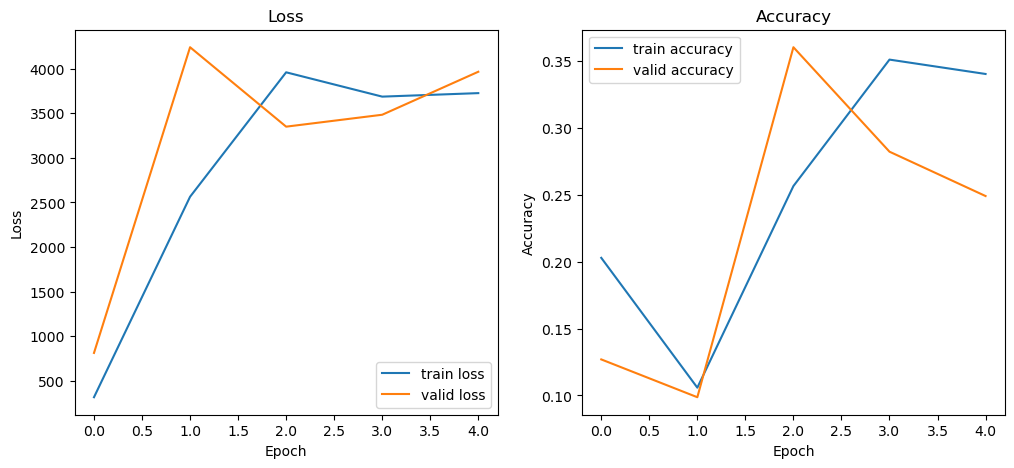

In [89]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plotting loss
ax1.plot(train_losses, label='train loss')
ax1.plot(valid_losses, label='valid loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plotting accuracy
ax2.plot(train_accuracies, label='train accuracy')
ax2.plot(valid_accuracies, label='valid accuracy')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

In [ ]:
#TODO adam nadam ------
#TODO xavier ------
#TODO wandb --------
#TODO weight decay -----
#TODO MSE  -----
#TODO Organize all optimizers
#TODO Define accuracy function ----
#TODO Organize all parameters in a dictionary -----


In [265]:
config = {"num_epochs": 5,
          "n_hidden": 5,
          "hidden_size": 128,
          "weight_decay": 0,
          "lr": 0.0001,
          "optimizer": "adam",
          "batch_size": 64,
          "weights_init" : 'xavier',
          "activation" : 'sigmoid'
          }

In [267]:
sweep_config = {
    'method': 'random'
}
metric = {
    'name': 'val_accuracy',
    'goal': 'maximize'   
}
sweep_config['metric'] = metric


In [279]:
parameters_dict = {
    "num_epochs": {'values': [5,10]},
    "n_hidden": {'values': [3,4,5]},
    "hidden_size": {'values': [32,64, 128]},
    "weight_decay": {'values': [0, 0.0005, 0.5]},
    "lr": {'values': [1e-3, 1e-4]},
    "optimizer": {'values': ['sgd', 'momentum', 'nag', 'rmsprop', 'adam', 'nadam']},
    "batch_size": {'values': [16, 32, 64]},
    "weights_init" : {'values': ['random', 'xavier']},
    "activation" : {'values': ['sigmoid', 'tanh', 'ReLU']},
    #"loss" : {'values': ['cross_entropy']}
    }

sweep_config['parameters'] = parameters_dict

In [ ]:
def tanh_derivative(x):
    return 1 - np.tanh(x)**2

(3, 3, 3)

In [280]:
import pprint
pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'maximize', 'name': 'val_accuracy'},
 'parameters': {'activation': {'values': ['sigmoid', 'tanh', 'ReLU']},
                'batch_size': {'values': [16, 32, 64]},
                'hidden_size': {'values': [32, 64, 128]},
                'lr': {'values': [0.001, 0.0001]},
                'n_hidden': {'values': [3, 4, 5]},
                'num_epochs': {'values': [5, 10]},
                'optimizer': {'values': ['sgd',
                                         'momentum',
                                         'nag',
                                         'rmsprop',
                                         'adam',
                                         'nadam']},
                'weight_decay': {'values': [0, 0.0005, 0.5]},
                'weights_init': {'values': ['random', 'xavier']}}}


In [ ]:
sweep_id = wandb.sweep(sweep_config, project="DAassignment1_test")

Create sweep with ID: emc1x181
Sweep URL: https://wandb.ai/deeplearn24/DAassignment1_test/sweeps/emc1x181


In [295]:
def train_wandb(config=None):
    with wandb.init(config=config):
        config = wandb.config
        (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
        labels = set(y_train)
        sample = {ind: np.where(y_train == ind)[0][0] for ind in labels}
        # getting validation data
        indices = list(np.arange(len(x_train)))
        np.random.shuffle(indices)
        x_train = x_train[indices]
        y_train = y_train[indices]
        x_train, x_valid = x_train[:50000], x_train[50000:]
        y_train, y_valid = y_train[:50000], y_train[50000:]


        # reshaping the data
        x_train = x_train.reshape(x_train.shape[0], 28*28)
        x_train = x_train/255.0
        #x_train = (x_train - x_train.mean())/x_train.std()
        x_valid = x_valid.reshape(x_valid.shape[0], 28*28)
        x_valid = x_valid/255.0
        #x_valid = (x_valid/x_valid.mean())/x_valid.std()
        x_test = x_test.reshape(x_test.shape[0], 28*28)
        x_test = x_test/255.0
        #x_test = (x_test/x_test.mean())/x_test.std()
        y_train = one_hot_encode(y_train)
        y_valid = one_hot_encode(y_valid)
        y_test = one_hot_encode(y_test)
        train = batch_data(x_train, y_train, config.batch_size)
        valid = batch_data(x_valid, y_valid, config.batch_size)
        loss = Loss(loss_fn='cross_entropy')
        optimizer = GradientDescent(optimizer=config.optimizer, lr=config.lr, clipping_threshold=threshold, beta=0.9, beta_2 = 0.999, eps = 1e-8)
        model = NeuralNet(input_size=x_train.shape[1], hidden_size=config.hidden_size, output_size=10, n_hidden=config.n_hidden, loss=loss, activation=[config.activation, "softmax"], weights_init = config.weights_init, weight_decay = config.weight_decay)


        train_losses = []
        valid_losses = []
        train_accuracies = []
        valid_accuracies = []
        for epoch in range(config.num_epochs):
            i=0
            print(f"Epoch: {epoch}")
            batch_train_loss = []
            batch_valid_loss = []
            batch_train_accuracy = []
            batch_valid_accuracy = []
            for (x,y),  (x_val, y_val) in zip(train, valid):

                loss, accuracy = optimizer.gradient_descent(model, x, y, i)
                batch_train_loss.append(loss)
                batch_train_accuracy.append(accuracy)

                valid_output, valid_loss, valid_accuracy = model(x_val, y_val)
                batch_valid_loss.append(valid_loss)
                batch_valid_accuracy.append(valid_accuracy)

                wandb.log({'train_batch_loss': loss})
                if i%1000 == 0:
                    print(f"validation loss: {valid_loss}")
                    print(f"validation accuracy: {valid_accuracy}")
                
                i+=1
            
            #clear_output(True)
            print(f"Average train loss in epoch {epoch}: {np.mean(batch_train_loss)}")
            print(f"Average valid loss in epoch {epoch}: {np.mean(batch_valid_loss)}")
            print(f"Average train accuracy in epoch {epoch}: {np.mean(batch_train_accuracy)}")
            print(f"Average valid accuracy in epoch {epoch}: {np.mean(batch_valid_accuracy)}")
            wandb.log({'train_loss': np.mean(batch_train_loss), 'valid_loss': np.mean(batch_valid_loss), 'train_accuracy': np.mean(batch_train_accuracy), 'valid_accuracy': np.mean(batch_valid_accuracy), "epoch": epoch})
            train_losses.append(np.mean(batch_train_loss))
            train_accuracies.append(np.mean(batch_train_accuracy))
            valid_losses.append(np.mean(batch_valid_loss))
            valid_accuracies.append(np.mean(batch_valid_accuracy))



        


In [296]:
wandb.agent(sweep_id, train_wandb, count=5)

wandb: Agent Starting Run: atl5pgvm with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hidden_size: 32
wandb: 	lr: 0.001
wandb: 	n_hidden: 5
wandb: 	num_epochs: 10
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weights_init: xavier


Epoch: 0
validation loss: 108.50360532954755
validation accuracy: 0.09375
Average train loss in epoch 0: 21250.23540528949
Average valid loss in epoch 0: 21345.224668706836
Average train accuracy in epoch 0: 0.10373402555910544
Average valid accuracy in epoch 0: 0.10033945686900958
Epoch: 1
validation loss: 59724.53775313767
validation accuracy: 0.125
Average train loss in epoch 1: 130130.6146724743
Average valid loss in epoch 1: 130349.41768363357
Average train accuracy in epoch 1: 0.10343450479233227
Average valid accuracy in epoch 1: 0.10223642172523961
Epoch: 2
validation loss: 196665.41532035655
validation accuracy: 0.125
Average train loss in epoch 2: 246121.99262313874
Average valid loss in epoch 2: 246277.50818972284
Average train accuracy in epoch 2: 0.10203674121405751
Average valid accuracy in epoch 2: 0.10373402555910544
Epoch: 3
validation loss: 293999.52032976726
validation accuracy: 0.125
Average train loss in epoch 3: 343679.37423934136
Average valid loss in epoch 3: 34

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,█▇▃▂▃▂▁▁▁▁
train_batch_loss,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▆▆▆▆▇▇▇▇▇▇████
train_loss,▁▁▂▂▃▃▄▆▇█
valid_accuracy,▁▅█▆▄▄▄▄▄▄
valid_loss,▁▁▂▂▃▃▄▆▇█
epoch,9
train_accuracy,0.10144
train_batch_loss,1838369.68384
train_loss,1690176.28304
valid_accuracy,0.10174


wandb: Agent Starting Run: ieyps3ac with config:
wandb: 	activation: ReLU
wandb: 	batch_size: 16
wandb: 	hidden_size: 64
wandb: 	lr: 0.0001
wandb: 	n_hidden: 5
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weights_init: random


Epoch: 0


Traceback (most recent call last):
  File "C:\Users\Srikrishnan\AppData\Local\Temp\ipykernel_2116\312579587.py", line 49, in train_wandb
    loss, accuracy = optimizer.gradient_descent(model, x, y, i)
  File "C:\Users\Srikrishnan\AppData\Local\Temp\ipykernel_2116\2165721299.py", line 21, in gradient_descent
    output, loss, acc = model(x,y)
  File "C:\Users\Srikrishnan\AppData\Local\Temp\ipykernel_2116\1723096026.py", line 59, in __call__
    x = layer(x)
  File "C:\Users\Srikrishnan\AppData\Local\Temp\ipykernel_2116\3115788903.py", line 33, in __call__
    hidden = input @ self.weights.T + self.bias
ValueError: matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)


Run ieyps3ac errored:
Traceback (most recent call last):
  File "c:\Users\Srikrishnan\miniconda3\envs\pytorch-gpu\lib\site-packages\wandb\agents\pyagent.py", line 306, in _run_job
    self._function()
  File "C:\Users\Srikrishnan\AppData\Local\Temp\ipykernel_2116\312579587.py", line 49, in train_wandb
    loss, accuracy = optimizer.gradient_descent(model, x, y, i)
  File "C:\Users\Srikrishnan\AppData\Local\Temp\ipykernel_2116\2165721299.py", line 21, in gradient_descent
    output, loss, acc = model(x,y)
  File "C:\Users\Srikrishnan\AppData\Local\Temp\ipykernel_2116\1723096026.py", line 59, in __call__
    x = layer(x)
  File "C:\Users\Srikrishnan\AppData\Local\Temp\ipykernel_2116\3115788903.py", line 33, in __call__
    hidden = input @ self.weights.T + self.bias
ValueError: matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

wandb: ERROR Run ieyps3ac errored:
wandb: ERROR Traceback (most recent call last):
wan

Epoch: 0


Traceback (most recent call last):
  File "C:\Users\Srikrishnan\AppData\Local\Temp\ipykernel_2116\312579587.py", line 49, in train_wandb
    loss, accuracy = optimizer.gradient_descent(model, x, y, i)
  File "C:\Users\Srikrishnan\AppData\Local\Temp\ipykernel_2116\2165721299.py", line 21, in gradient_descent
    output, loss, acc = model(x,y)
  File "C:\Users\Srikrishnan\AppData\Local\Temp\ipykernel_2116\1723096026.py", line 59, in __call__
    x = layer(x)
  File "C:\Users\Srikrishnan\AppData\Local\Temp\ipykernel_2116\3115788903.py", line 33, in __call__
    hidden = input @ self.weights.T + self.bias
ValueError: matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)


Run emayo5q5 errored:
Traceback (most recent call last):
  File "c:\Users\Srikrishnan\miniconda3\envs\pytorch-gpu\lib\site-packages\wandb\agents\pyagent.py", line 306, in _run_job
    self._function()
  File "C:\Users\Srikrishnan\AppData\Local\Temp\ipykernel_2116\312579587.py", line 49, in train_wandb
    loss, accuracy = optimizer.gradient_descent(model, x, y, i)
  File "C:\Users\Srikrishnan\AppData\Local\Temp\ipykernel_2116\2165721299.py", line 21, in gradient_descent
    output, loss, acc = model(x,y)
  File "C:\Users\Srikrishnan\AppData\Local\Temp\ipykernel_2116\1723096026.py", line 59, in __call__
    x = layer(x)
  File "C:\Users\Srikrishnan\AppData\Local\Temp\ipykernel_2116\3115788903.py", line 33, in __call__
    hidden = input @ self.weights.T + self.bias
ValueError: matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

wandb: ERROR Run emayo5q5 errored:
wandb: ERROR Traceback (most recent call last):
wan

Epoch: 0
validation loss: 2.805897502064791
validation accuracy: 0.09375
Average train loss in epoch 0: 41.45171881624581
Average valid loss in epoch 0: 41.57157298928175
Average train accuracy in epoch 0: 0.1009384984025559
Average valid accuracy in epoch 0: 0.10063897763578275
Epoch: 1
validation loss: 80.85561461618883
validation accuracy: 0.09375
Average train loss in epoch 1: 120.67243316920025
Average valid loss in epoch 1: 120.80097428186174
Average train accuracy in epoch 1: 0.10203674121405751
Average valid accuracy in epoch 1: 0.10193690095846646
Epoch: 2
validation loss: 161.7026688599099
validation accuracy: 0.125
Average train loss in epoch 2: 204.24737229661613
Average valid loss in epoch 2: 204.38608407174397
Average train accuracy in epoch 2: 0.10103833865814696
Average valid accuracy in epoch 2: 0.10123801916932908
Epoch: 3
validation loss: 248.65979672478198
validation accuracy: 0.125
Average train loss in epoch 3: 295.70357990007653
Average valid loss in epoch 3: 295

epoch,▁▃▅▆█
train_accuracy,▁▂▁▃█
train_batch_loss,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
train_loss,▁▃▄▆█
valid_accuracy,▁▃▂▅█
valid_loss,▁▃▄▆█
epoch,4
train_accuracy,0.11122
train_batch_loss,453.79335
train_loss,398.32411
valid_accuracy,0.10483


wandb: Agent Starting Run: og786a5m with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	hidden_size: 64
wandb: 	lr: 0.0001
wandb: 	n_hidden: 4
wandb: 	num_epochs: 10
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weights_init: xavier


Epoch: 0
validation loss: 2.50335293278006
validation accuracy: 0.125
Average train loss in epoch 0: 55.36248976396973
Average valid loss in epoch 0: 55.44680774896903
Average train accuracy in epoch 0: 0.098
Average valid accuracy in epoch 0: 0.0966
Epoch: 1
validation loss: 110.87793827960925
validation accuracy: 0.125
Average train loss in epoch 1: 170.83686273478008
Average valid loss in epoch 1: 170.93457873326767
Average train accuracy in epoch 1: 0.1091
Average valid accuracy in epoch 1: 0.1119
Epoch: 2
validation loss: 233.24771181931624
validation accuracy: 0.0625
Average train loss in epoch 2: 299.081979348522
Average valid loss in epoch 2: 299.1892204702611
Average train accuracy in epoch 2: 0.1414
Average valid accuracy in epoch 2: 0.144
Epoch: 3
validation loss: 367.210828573104
validation accuracy: 0.125
Average train loss in epoch 3: 438.7457042465037
Average valid loss in epoch 3: 438.8625000279041
Average train accuracy in epoch 3: 0.0988
Average valid accuracy in epoc

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▃▄█▃▁▁▄▄▄▅
train_batch_loss,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇███
train_loss,▁▂▂▃▃▄▅▆▇█
valid_accuracy,▃▅█▃▁▁▄▃▃▄
valid_loss,▁▂▂▃▃▄▅▆▇█
epoch,9
train_accuracy,0.1099
train_batch_loss,1717.22521
train_loss,1595.79077
valid_accuracy,0.1074
